In [122]:
import pandas as pd

# Load the data
df = pd.read_csv('data/VIW_FNT.csv')

df['ISO_WEEKSTARTDATE'] = pd.to_datetime(df['ISO_WEEKSTARTDATE'])

cutoff_date = pd.Timestamp('2022-01-01')

df = df[df['ISO_WEEKSTARTDATE'] <= cutoff_date]


Load the cvsfile, and remove rows that are still in the future or too recent 

In [124]:
df.rename(columns={
    'ITZ': 'FluZone',
    'SPEC_RECEIVED_NB': 'Received',
    'SPEC_PROCESSED_NB': 'Processed',
    'ALL_INF': 'PositiveFlu',
    'ALL_INF2': 'NegativeFlu',
    'INF_A' : 'PositiveTypeA',
    'INF_B' : 'PositiveTypeB',
    'INF_ALL' : 'Positive',
    'INF_NEGATIVE' : 'Negative'
}, inplace=True)

Rename several columns in the DataFrame so that their meaning is clearer

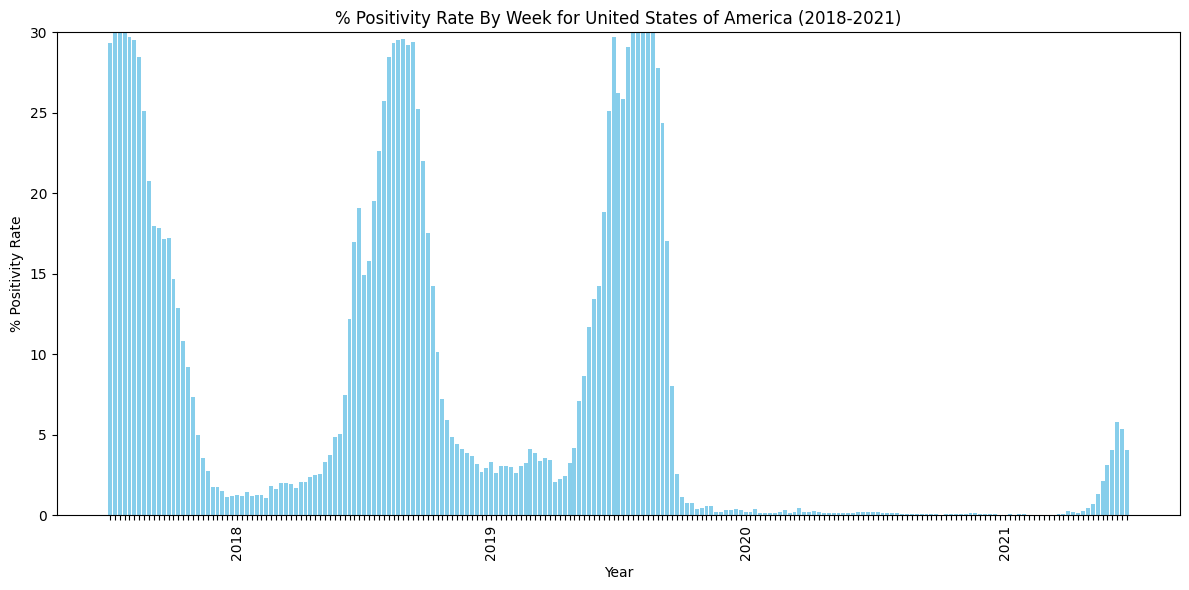

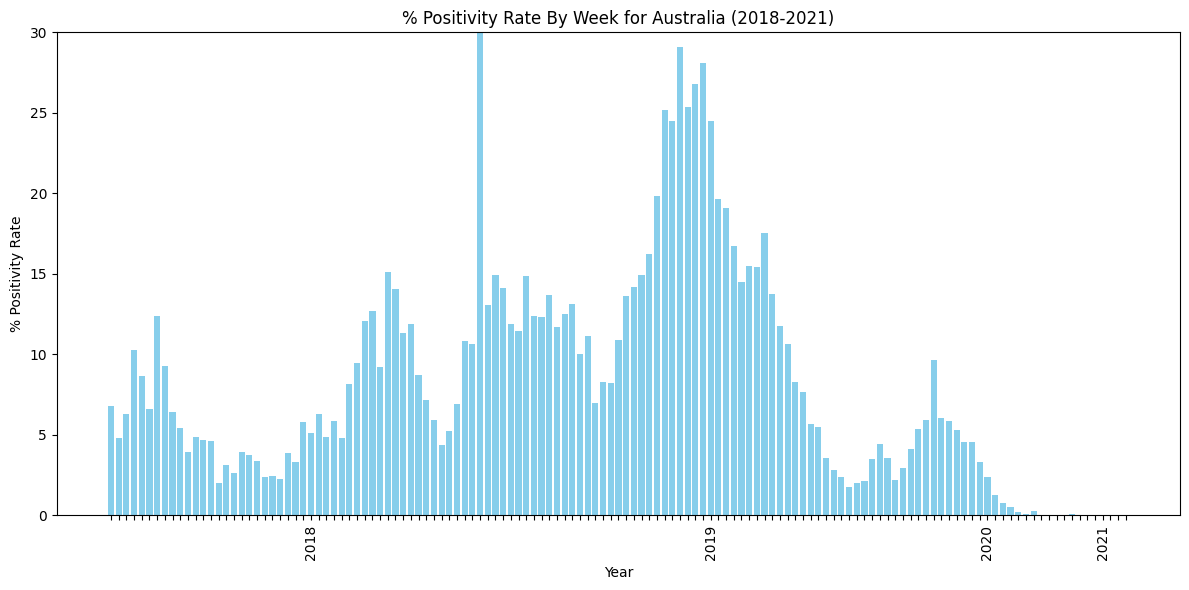

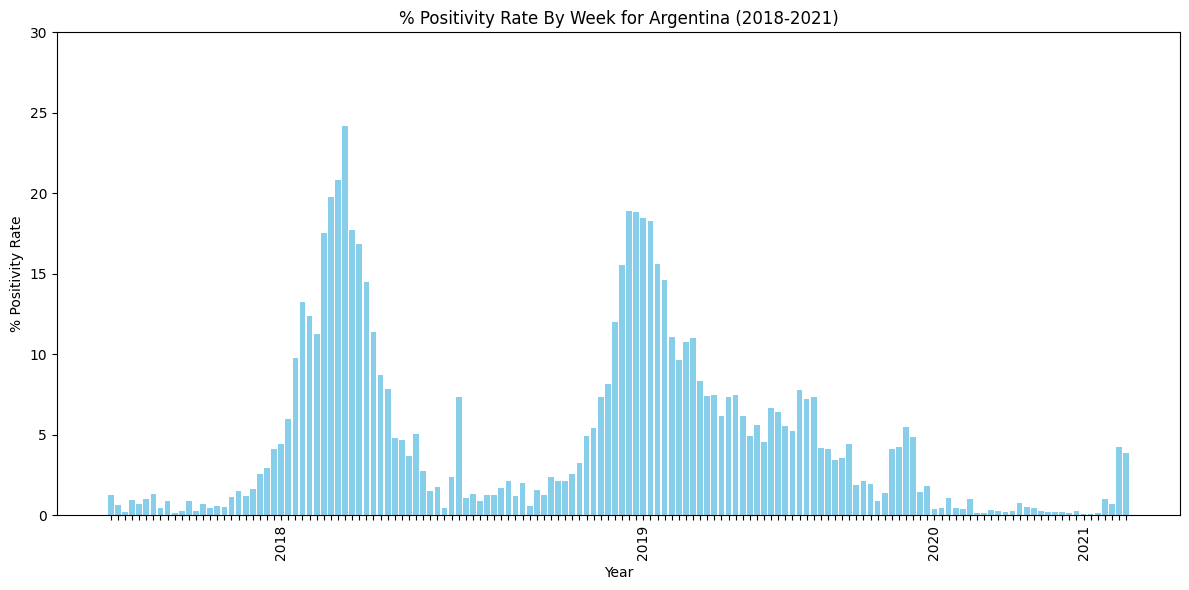

In [114]:
import matplotlib.pyplot as plt
import numpy as np

def create_positivity_rate_dataframe(df: pd.DataFrame, country = None, start_year=2018, end_year=2021) -> pd.DataFrame:
    """
    Creates a DataFrame with positivity rates by week for a given country from start_year to end_year.
    
    Parameters:
    df (DataFrame): The original DataFrame containing the COVID data.
    country (str): The name of the country to filter on.
    start_year (int): The start year for the DataFrame (default 2018).
    end_year (int): The end year for the DataFrame (default 2021).
    
    Returns:
    DataFrame: A DataFrame with weeks as the index, positivity rates, and country name.
    """
    # Filter the DataFrame for the specified country
    if country != None:
        df_country = df[df['COUNTRY_AREA_TERRITORY'] == country].copy()
    else:
        df_country = df.copy()
    
    # Calculate total tests
    df_country['Total_Tests'] = df_country['Positive'] + df_country['Negative']

    # Group by year, week, and country, summing the values
    df_grouped = df_country.groupby(['FluZone','COUNTRY_AREA_TERRITORY', 'ISO_YEAR', 'ISO_WEEK']).agg({
        'Positive': 'sum',
        'Negative': 'sum',
        'Total_Tests': 'sum'
    }).reset_index()

    # Calculate positivity rate
    df_grouped['%Positivity Rate'] = (df_grouped['Positive'] * 100) / df_grouped['Total_Tests']

    # Handle NaN and infinite values
    df_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_grouped.dropna(subset=['%Positivity Rate'], inplace=True)

    # Filter only the years from start_year to end_year
    df_grouped = df_grouped[(df_grouped['ISO_YEAR'] >= start_year) & (df_grouped['ISO_YEAR'] <= end_year)]
    
    # Combine year and week into 'Year_Week'
    df_grouped['Year_Week'] = df_grouped['ISO_YEAR'].astype(str) + '-' + df_grouped['ISO_WEEK'].astype(str)

    # Set 'Year_Week' as the new index
    df_grouped.set_index('Year_Week', inplace=True)

    # Sort the DataFrame by 'ISO_YEAR' and 'ISO_WEEK'
    df_grouped.sort_values(by=['ISO_YEAR', 'ISO_WEEK'], ascending=True, inplace=True)

    return df_grouped


def plot_positivity_rate(df_grouped: pd.DataFrame, country: str):
    """
    Plots the positivity rate by week for a given country.
    
    Parameters:
    df_grouped (DataFrame): The DataFrame containing positivity rates indexed by year and week.
    country (str): The name of the country for the plot title.
    """
    # Create the bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_grouped.index, df_grouped['%Positivity Rate'], color='skyblue')

    # Prepare x-axis labels to print the year at the middle week of each year
    unique_years = df_grouped['ISO_YEAR'].unique()  # Get the unique years
    x_labels = [''] * len(df_grouped)  # Empty list to store labels

    for year in unique_years:
        year_indices = df_grouped[df_grouped['ISO_YEAR'] == year].index
        # Find the middle index of this year's data
        middle_index = len(year_indices) // 2
        # Set the label to the middle week's index
        x_labels[df_grouped.index.get_loc(year_indices[middle_index])] = str(year)

    plt.xticks(df_grouped.index, x_labels, rotation=90)
    plt.title(f'% Positivity Rate By Week for {country} ({df_grouped.index[0].split("-")[0]}-{df_grouped.index[-1].split("-")[0]})')
    plt.xlabel('Year')
    plt.ylabel('% Positivity Rate')
    plt.ylim(0, 30)  # Set y-axis limit to 30%
    plt.tight_layout()  
    plt.show()


countries = ['United States of America', 'Australia', 'Argentina']

for country in countries:
    positivity_df = create_positivity_rate_dataframe(df, country)
    plot_positivity_rate(positivity_df, country)


 Compute and plot "U.S. Flu Positivity Rate by Week". Then, creating similar data plots for each of the countries: Canada, Australia, and Argentina. 

In [58]:
total_rows = df.shape[0]  

# Condition 1: c
condition_met = df['Processed'] > df['Received']
count_met = condition_met.sum()  # Number of rows where the condition is met

percentage_1 = round((count_met / total_rows) * 100, 2) if total_rows > 0 else 0

# Condition 2: Positive + Negative > Processed
condition_met = df['Positive'] + df['Negative'] > df['Processed']
count_met = condition_met.sum()
percentage_2 = round((count_met / total_rows) * 100, 2) if total_rows > 0 else 0

# Condition 3: PositiveTypeA + PositiveTypeB > Positive
condition_met = df['PositiveTypeA'] + df['PositiveTypeB'] > df['Positive']
count_met = condition_met.sum()
percentage_3 = round((count_met / total_rows) * 100, 2) if total_rows > 0 else 0


print(f'There are {percentage_1} % rows which Processed > Received')
print(f'There are {percentage_2} % rows which  "Total Positive" + "Total Negative" > Processed')
print(f'There are {percentage_3} % rows which "Total Positive" is not equal to ("Positive Type A" + "Positive Type B"')



There are 1.63 % rows which Processed > Received
There are 0.57 % rows which  "Total Positive" + "Total Negative" > Processed
There are 0.0 % rows which "Total Positive" is not equal to ("Positive Type A" + "Positive Type B"


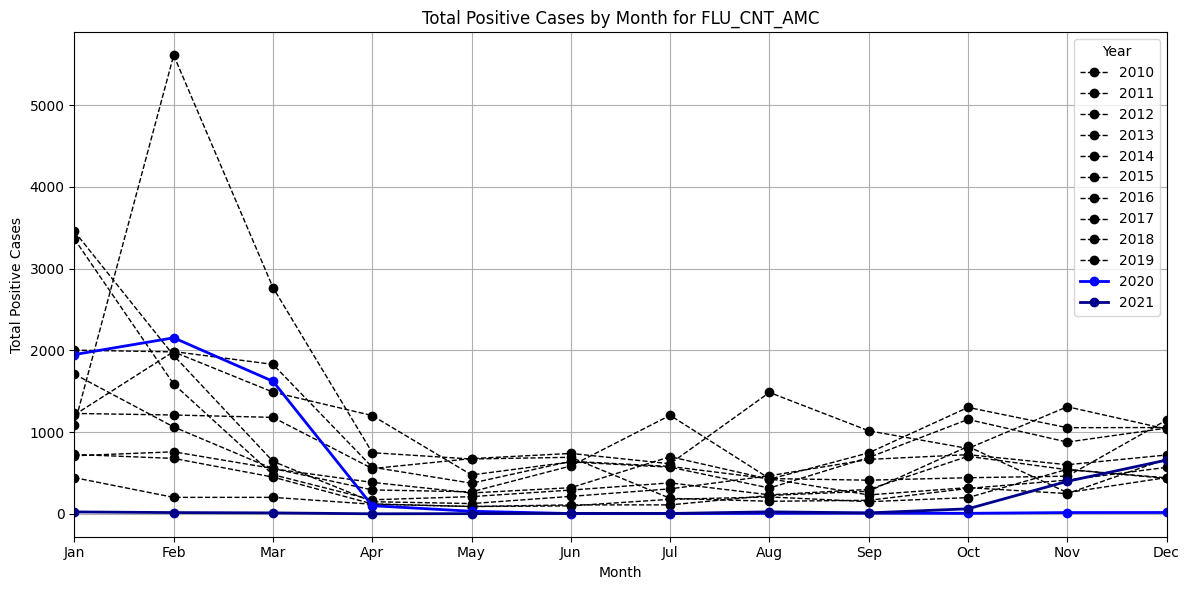

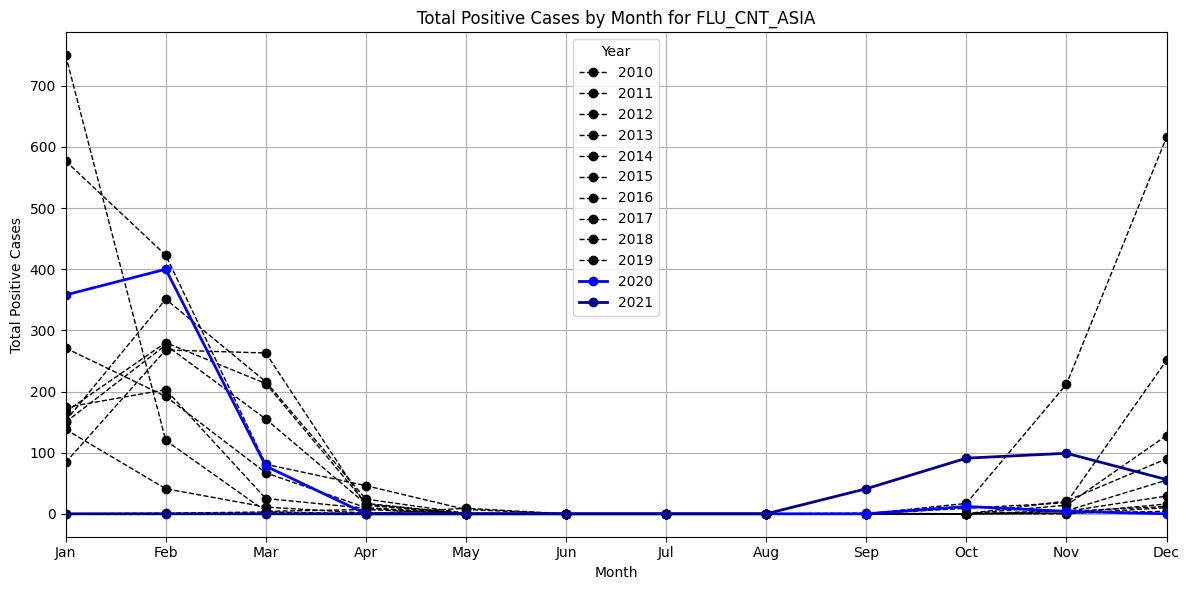

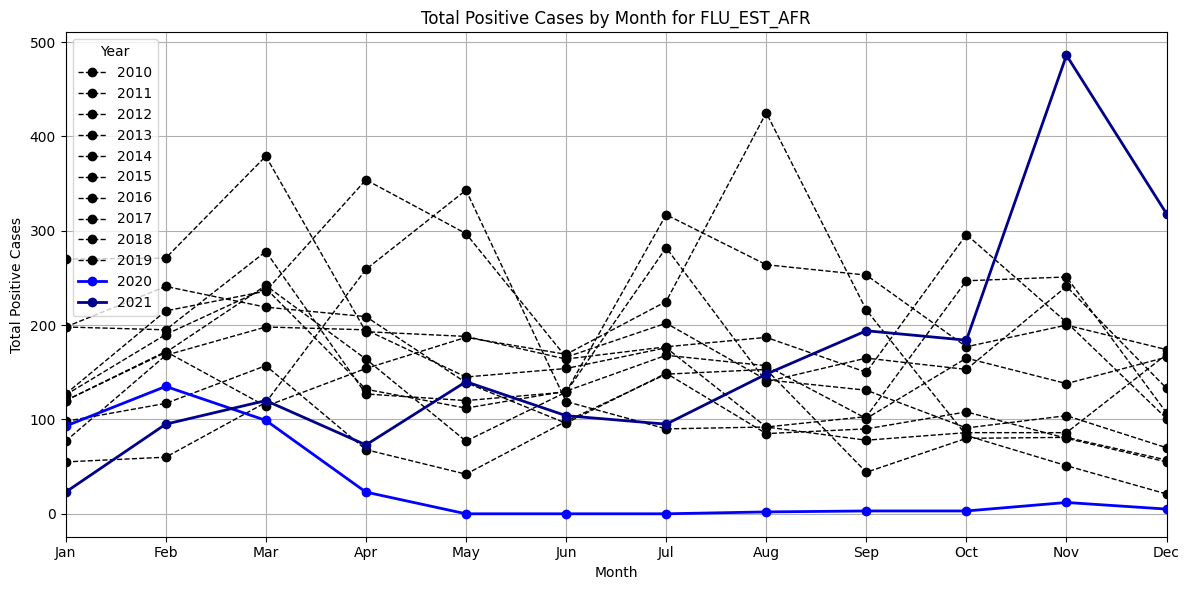

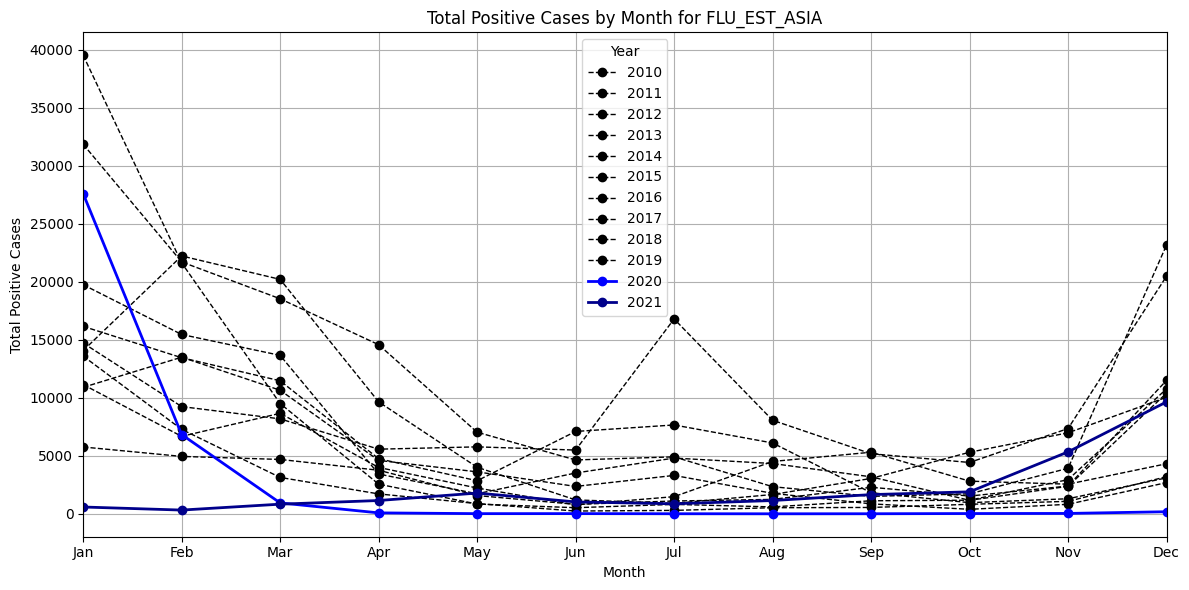

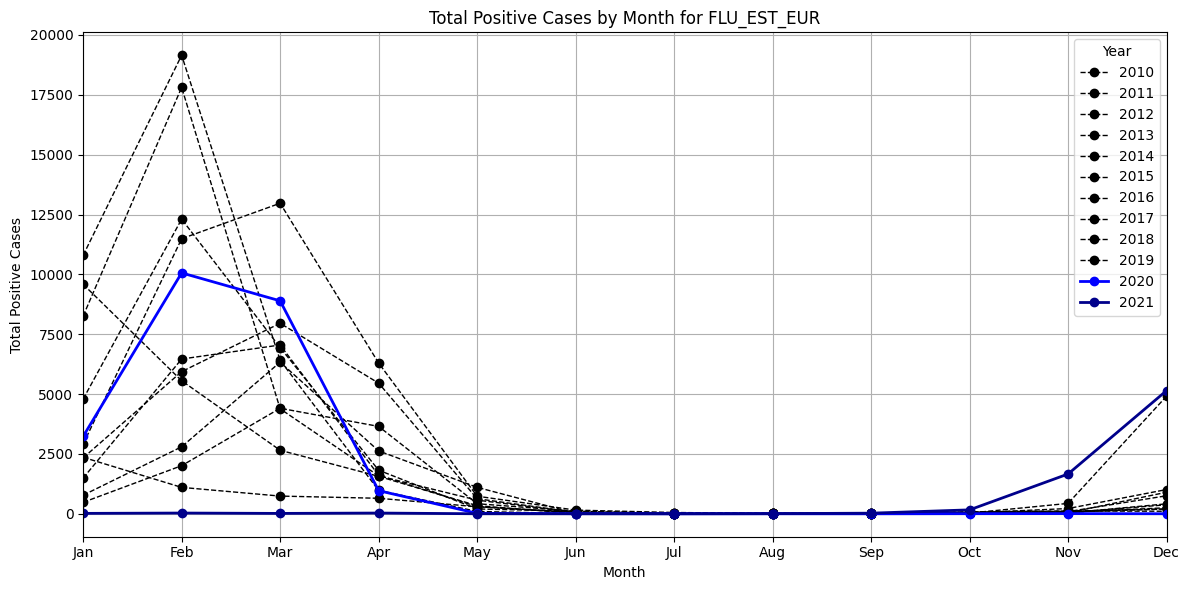

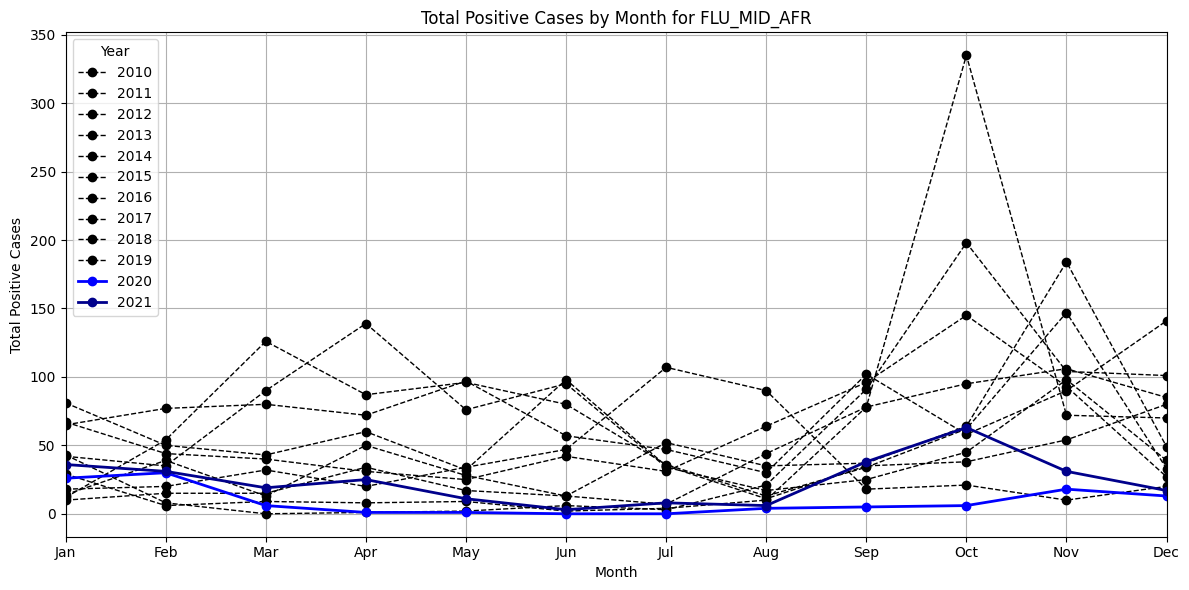

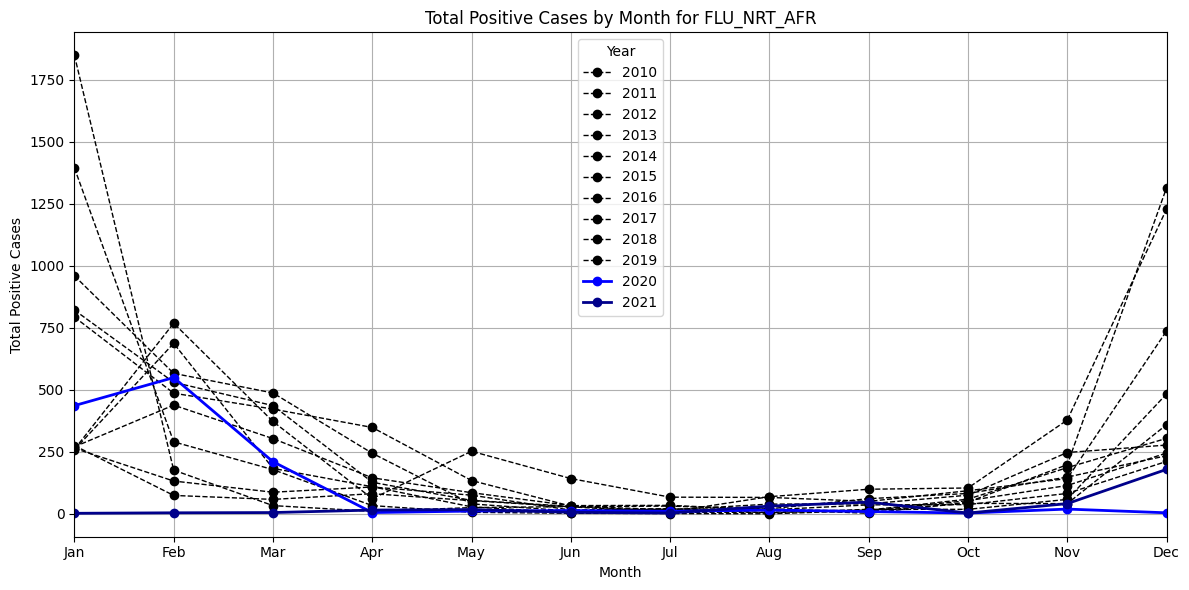

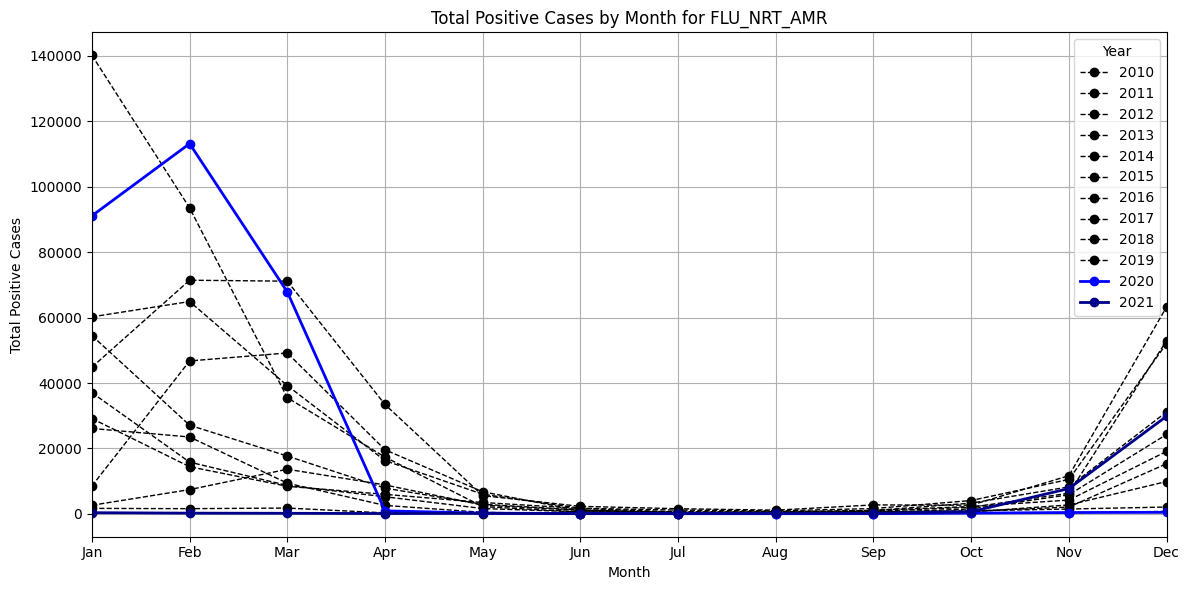

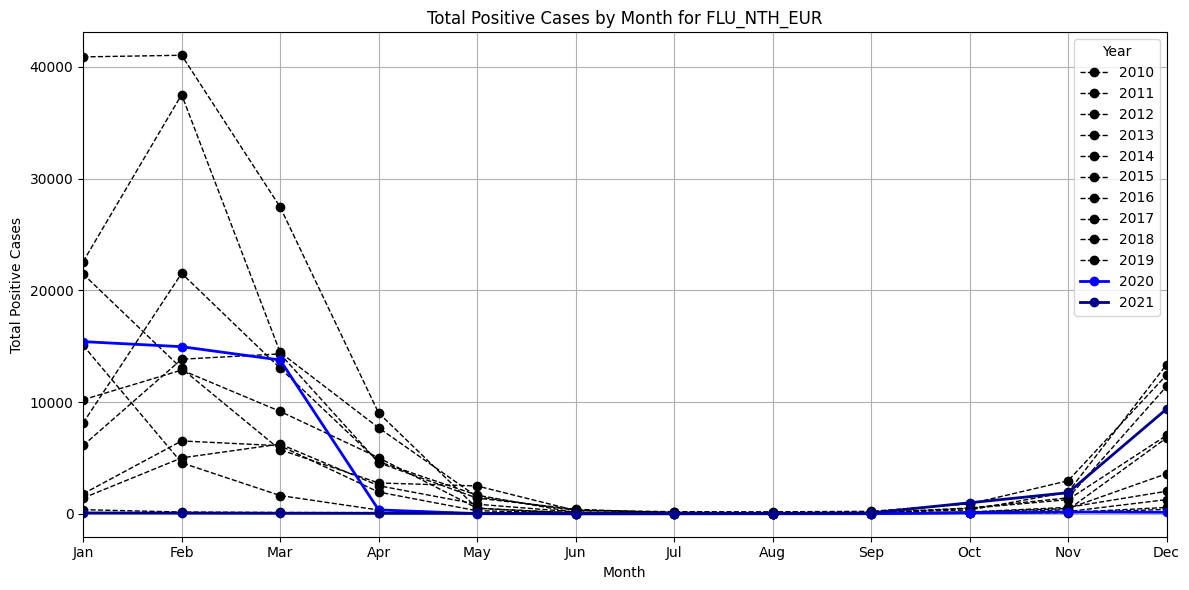

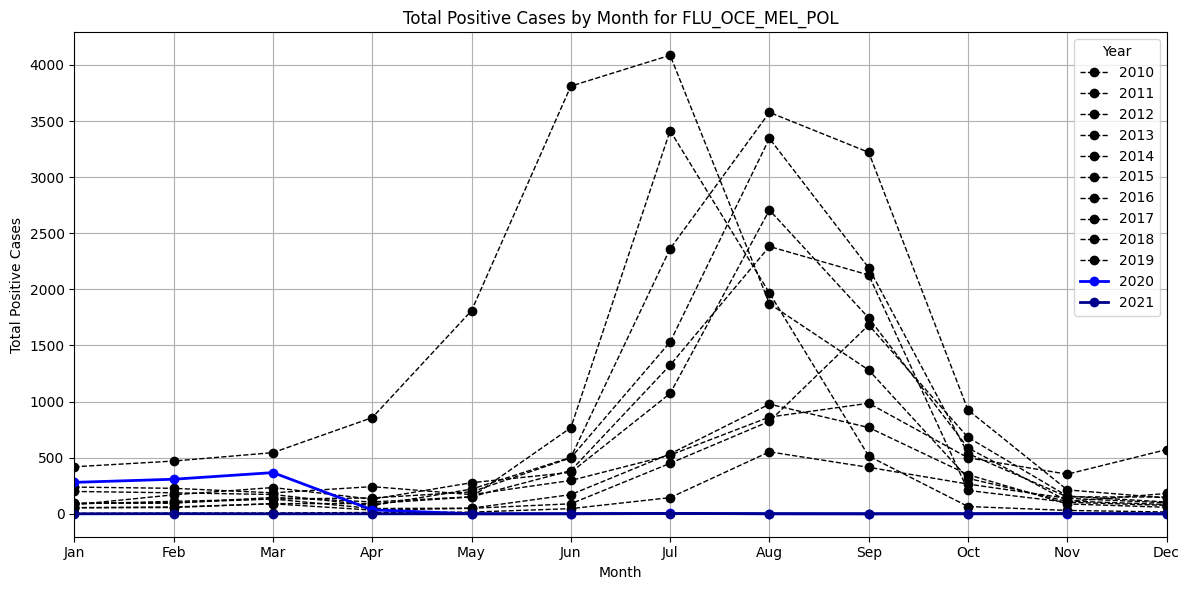

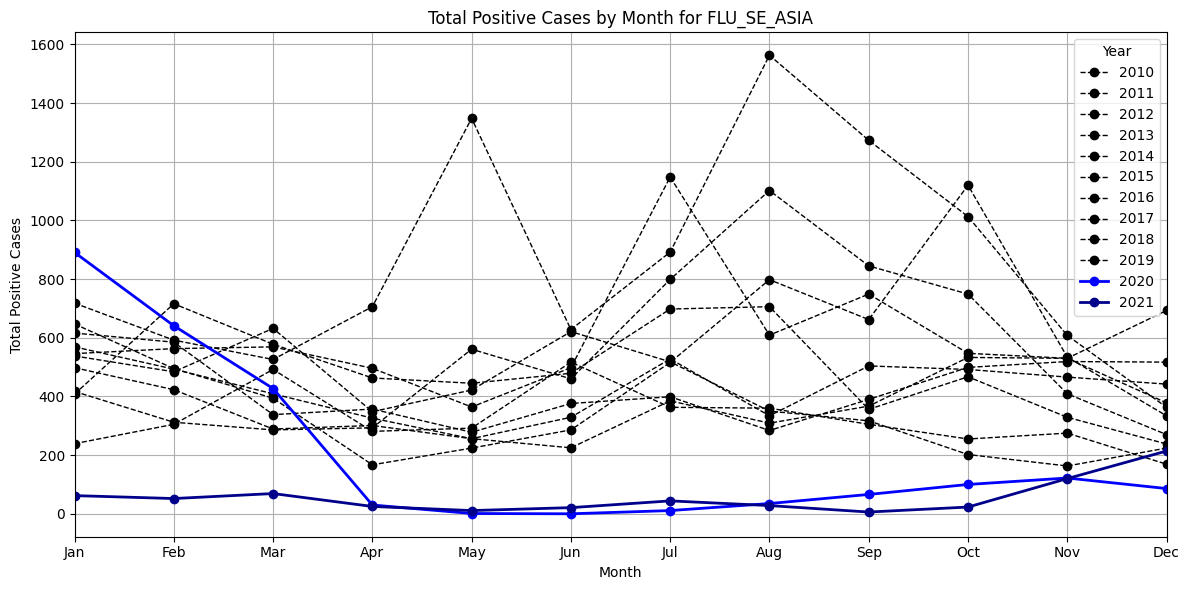

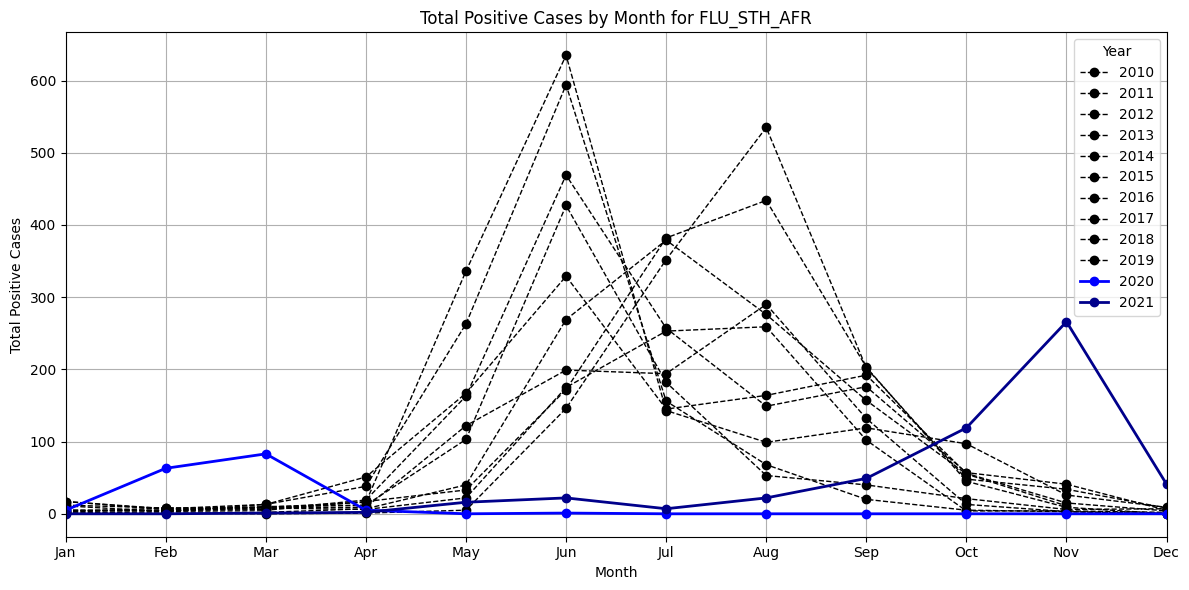

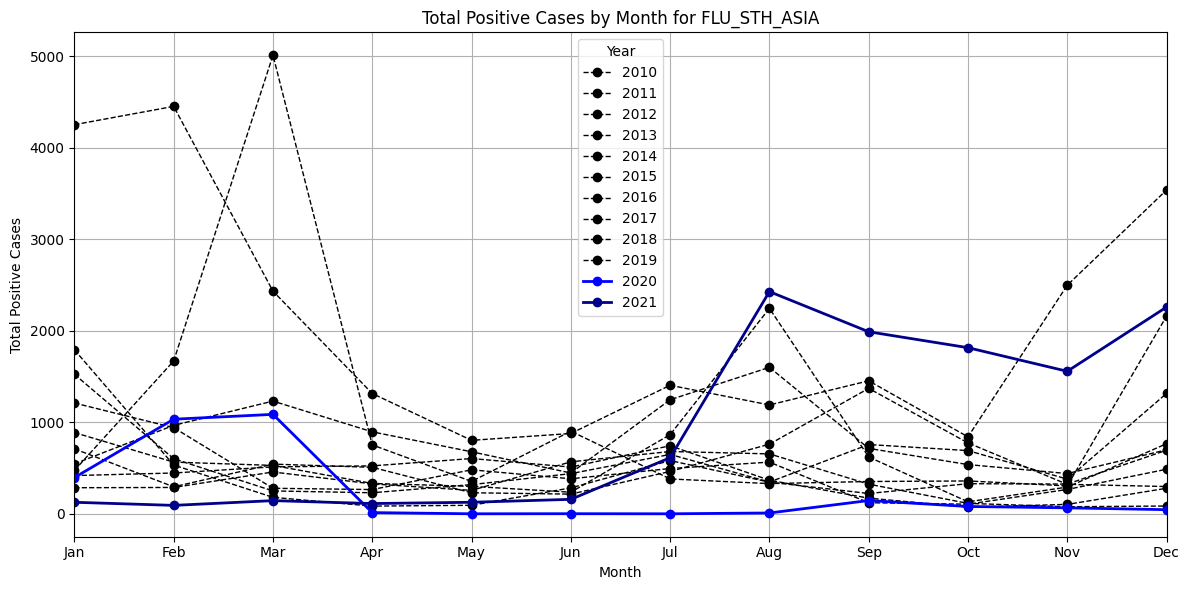

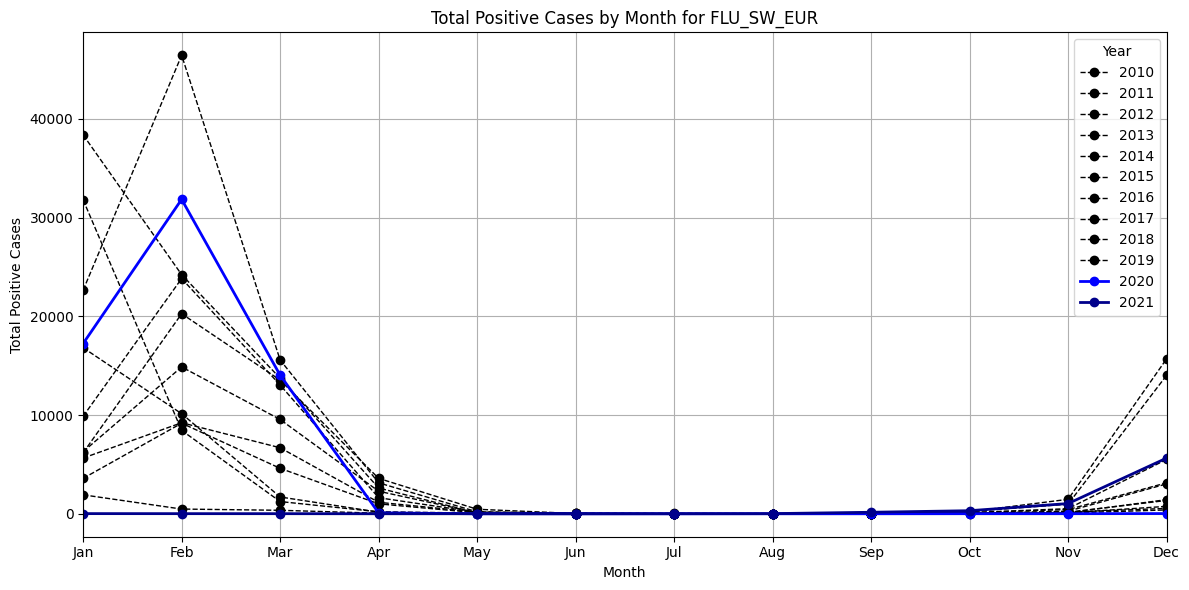

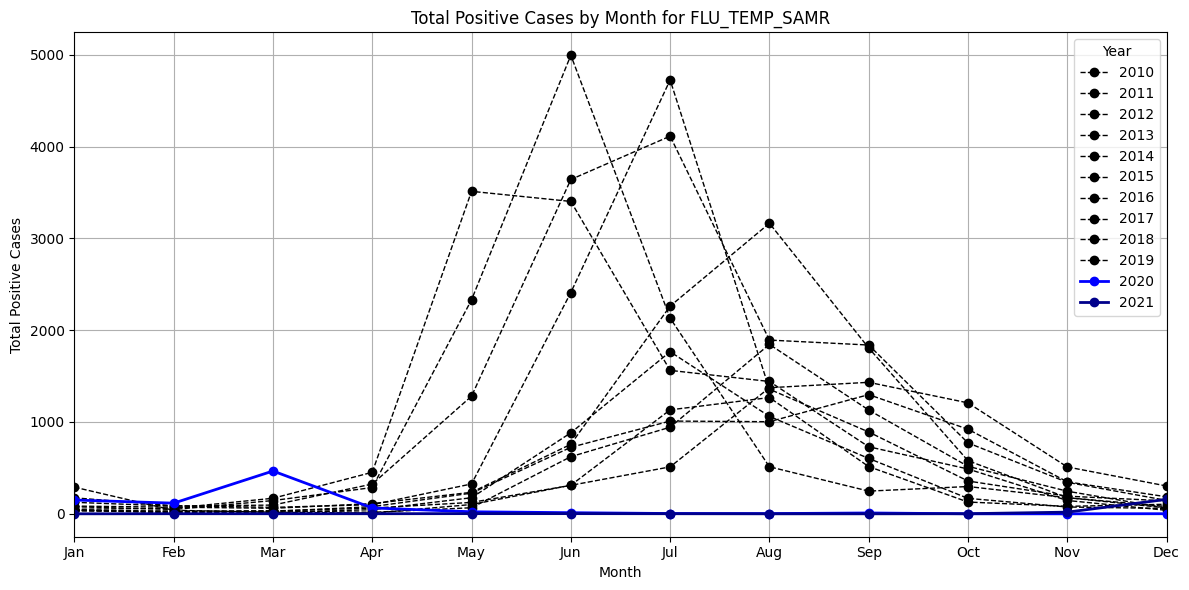

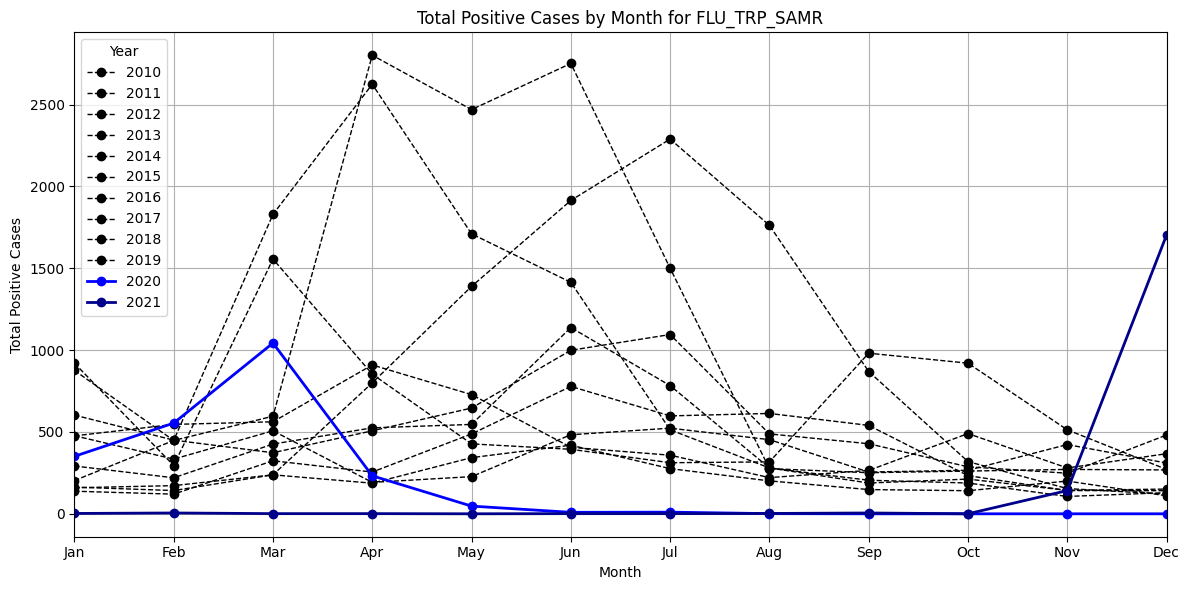

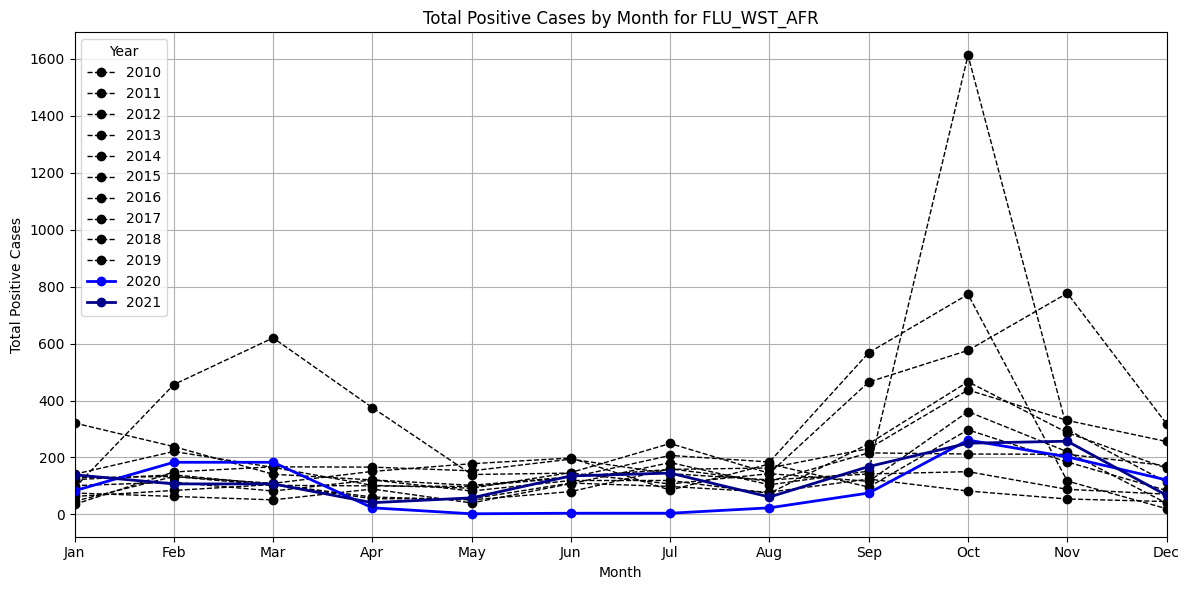

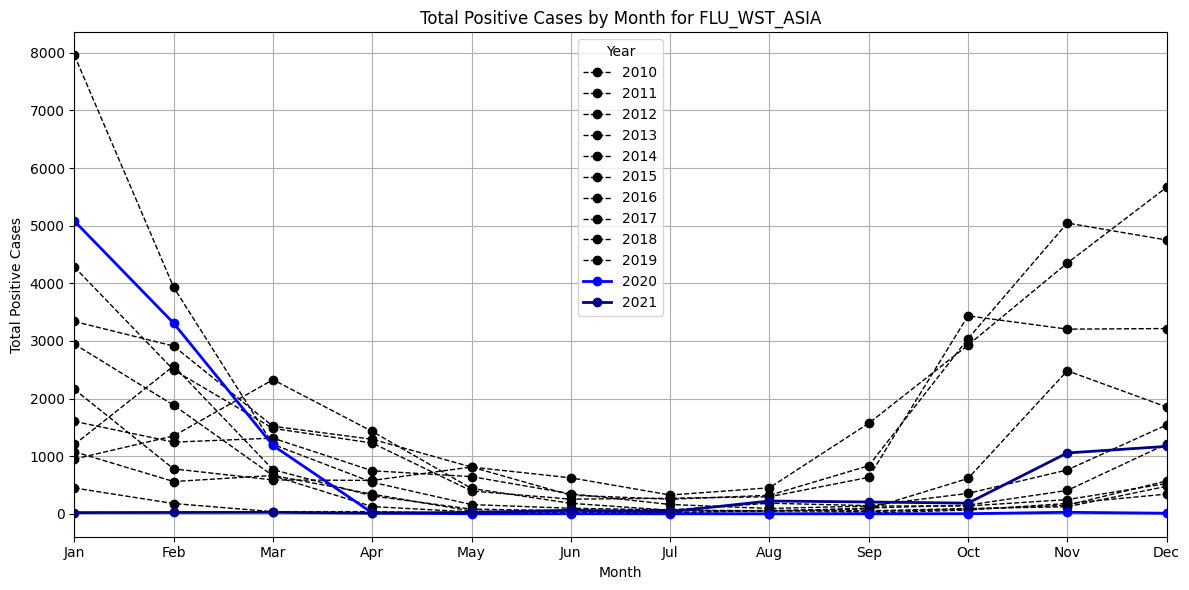

In [130]:
def count_total_positive_cases_by_month(df: pd.DataFrame, start_year=2010, end_year=2021) -> pd.DataFrame:
    """
    Counts total positive cases for each FluZone grouped by month and year.
    
    Parameters:
    df (DataFrame): The original DataFrame containing the COVID data.
    start_year (int): The start year for filtering (default 2012).
    end_year (int): The end year for filtering (default 2021).
    
    Returns:
    DataFrame: A DataFrame containing total positive cases grouped by FluZone, month, and year.
    """
    # Filter for the specified years
    df_filtered = df[(df['ISO_YEAR'] >= start_year) & (df['ISO_YEAR'] <= end_year)].copy()  # Make a copy to avoid warnings

    # Calculate the first date of the week to extract month
    df_filtered['Date'] = pd.to_datetime(df_filtered['ISO_YEAR'].astype(str) + '-W' + df_filtered['ISO_WEEK'].astype(str) + '-1', format='%Y-W%W-%w')

    # Create a new column for month using .loc
    df_filtered.loc[:, 'ISO_MONTH'] = df_filtered['Date'].dt.month

    # Group by FluZone, month, and year to count total positive cases
    flu_zone_counts = df_filtered.groupby(['FluZone', 'ISO_MONTH', 'ISO_YEAR']).agg({'Positive': 'sum'}).reset_index()

    return flu_zone_counts


def plot_positive_cases_by_flu_zone(flu_zone_counts: pd.DataFrame):
    """
    Plots total positive cases by month for each FluZone, with lines representing different years.
    
    Parameters:
    flu_zone_counts (DataFrame): DataFrame containing total positive cases grouped by FluZone, month, and year.
    """
    unique_flu_zones = flu_zone_counts['FluZone'].unique()  # Get unique FluZones

    for flu_zone in unique_flu_zones:
        zone_data = flu_zone_counts[flu_zone_counts['FluZone'] == flu_zone]  # Filter data for the specific FluZone

        plt.figure(figsize=(12, 6))  # Set the figure size

        # Plot each year as a separate line with clear distinction for 2020 and 2021
        for year in zone_data['ISO_YEAR'].unique():
            year_data = zone_data[zone_data['ISO_YEAR'] == year]

            # Use specific colors for 2020, 2021, and a near-black color for other years
            if year == 2020:
                plt.plot(year_data['ISO_MONTH'], year_data['Positive'], 
                         marker='o', linestyle='-', linewidth=2, 
                         color='blue',  # Blue for 2020
                         label=str(year))
            elif year == 2021:
                plt.plot(year_data['ISO_MONTH'], year_data['Positive'], 
                         marker='o', linestyle='-', linewidth=2, 
                         color='darkblue',  # Dark blue for 2021
                         label=str(year))
            else:
                plt.plot(year_data['ISO_MONTH'], year_data['Positive'], 
                         marker='o', linestyle='--', linewidth=1, 
                         color='black',  # Near-black for other years
                         label=str(year))

        # Set plot details
        plt.title(f'Total Positive Cases by Month for {flu_zone}')
        plt.xlabel('Month')
        plt.ylabel('Total Positive Cases')
        plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set x ticks for months
        plt.xlim(1, 12)  # Limit x-axis to valid months
        plt.grid(True)  # Add grid for easier readability
        plt.tight_layout()
        plt.legend(title='Year')
        plt.show()  # Show the plot for the current FluZone

# Count total positive cases grouped by FluZone, month, and year
flu_zone_counts = count_total_positive_cases_by_month(df)

# Plot total positive cases by FluZone
plot_positive_cases_by_flu_zone(flu_zone_counts)